# Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import turbine_classes
import os
from wakepy import set_keepawake, unset_keepawake
import pickle
from scipy.interpolate import interp1d

# File loading

In [2]:
filelist = ["/".join(["2T", _]) for _ in os.listdir("2T")] + ["/".join(["3T", _]) for _ in os.listdir("3T")]
for file in filelist:
    globals()[file.split(".")[0].split("/")[-1]] = dict()
    glob = globals()[file.split(".")[0].split("/")[-1]]
    filtlines = list()
    headerline = open(file).readlines()[0]
    headerline = headerline.replace("K ", "K_")
    headerlinesplit = [_ for _ in headerline.split(" ") if _ != ""]
    for header in headerlinesplit:
        if "\n" in header:
            header = header.replace("\n", "")
        glob[header] = list()
    for line in open(file).readlines():
        filtline = list()
        linesplit = [_ for _ in line.split(" ") if _ != ""]        
        if linesplit[0] in ["Z", "Generation"]:
            pass
        else:
            for e, datanum in enumerate(linesplit[:-1]):
                filtline.append(float(datanum))
        if len(filtline) == 0:
            pass
        else:
            for e, header in enumerate(headerlinesplit):
                if "\n" in header:
                    header = header.replace("\n", "")                
                glob[header].append(filtline[e])
    if "proc_genes" not in file:
        for key in glob.keys():
            glob[key] = [glob[key][40*e:40*(e + 1)] for e in range(0, 40)]

# Polar loading

In [2]:
polars = turbine_classes.polar_database_load(filepath=os.path.dirname("POLARS"), pick=True)

# Calculations for best turbine configurations with $Z$=3

## Mono and counter calculations

In [4]:
proc_genes_dataname = [_ for _ in globals() if "proc_genes" in _ and "IDOM" in _ and "mins" not in _]
proc_genes_data = [globals()[_] for _ in proc_genes_dataname]
turbs = list()
mono_sols = list()
fitnesses = list()
for e, proc_genes in enumerate(proc_genes_data):
    print(proc_genes_dataname[e])
    N = 50
    omega = 2100
    Nmin = 1000
    Nmax = 3200
    rcas = 0.5 if "r05" in proc_genes_dataname[e] else 0.4
    polars = polars
    cpobjs = [933.78, 1089.41, 1089.41, 1011.59, 1011.59, 1011.59, 933.78, 933.78, 933.78, 855.96] if "3T" in proc_genes_dataname[e] else [622.52, 726.2733333333334, 726.2733333333334, 674.3933333333333, 674.3933333333333, 674.3933333333333, 622.52, 622.52, 622.52, 570.64]
    devobjs = [2170.82, 2851.59, 2931.97, 2781.80, 2542.296783, 4518.520988, 4087.436172, 3806.379812, 5845.986619, 6745.134759]
    weights = [0.1085, 0.1160, 0.1188, 0.0910, 0.0824, 0.1486, 0.0882, 0.0867, 0.0945, 0.0652]
    mode = "mono" if "Mono" in proc_genes_dataname[e] else "counter" if "Counter" in proc_genes_dataname[e] else "pitchopt"
    constargs = {"N": N,
                 "omega": omega,
                 "rcas": rcas,
                 "polars": polars,
                 "cpobjs": cpobjs,
                 "devobjs": devobjs,
                 "weights": weights,
                 "Nmin": Nmin,
                 "Nmax": Nmax,
                 "Mode": mode}    
    solution = list()
    for key in ["Z", "sigma_hub", "sigma_tip", "hub_to_tip_ratio"]:
        solution.append(proc_genes[key][0])
    if mode == "mono":
        mono_sols.append([proc_genes_dataname[e]] + solution)
    turbs.append(turbine_classes.instantiate_turbine(constargs, solution))
    fitnesses.append(turbine_classes.fitness_func(constargs=constargs, turb=turbs[-1], out='stfitness'))

Counter_fit_IDOM_r04_2T_proc_genes
Counter_fit_IDOM_r05_2T_proc_genes
Mono_fit_IDOM_r04_2T_proc_genes
Mono_fit_IDOM_r05_2T_proc_genes
Pitchopt_fit_IDOM_r04_opts_2T_proc_genes
Pitchopt_fit_IDOM_r05_opts_2T_proc_genes
Counter_fit_IDOM_r04_3T_proc_genes
Counter_fit_IDOM_r05_3T_proc_genes
Mono_fit_IDOM_r04_3T_proc_genes
Mono_fit_IDOM_r05_3T_proc_genes
Pitchopt_fit_IDOM_r04_opts_3T_proc_genes
Pitchopt_fit_IDOM_r05_opts_3T_proc_genes


## Pitchopt turbine calculations for best mono configurations

In [5]:
# Keeping awake.
set_keepawake(keep_screen_awake=False)

for mono_sol in mono_sols:
    proc_genes_dataname.append(mono_sol[0].replace("Mono", "Pitchopt_for_mono"))
    N = 50
    omega = 2100
    Nmin = 1000
    Nmax = 3200
    rcas = 0.5 if "r05" in mono_sol[0] else 0.4
    polars = polars
    cpobjs = [933.78, 1089.41, 1089.41, 1011.59, 1011.59, 1011.59, 933.78, 933.78, 933.78, 855.96] if "3T" in mono_sol[0] else [622.52, 726.2733333333334, 726.2733333333334, 674.3933333333333, 674.3933333333333, 674.3933333333333, 622.52, 622.52, 622.52, 570.64]
    devobjs = [2170.82, 2851.59, 2931.97, 2781.80, 2542.296783, 4518.520988, 4087.436172, 3806.379812, 5845.986619, 6745.134759]
    weights = [0.1085, 0.1160, 0.1188, 0.0910, 0.0824, 0.1486, 0.0882, 0.0867, 0.0945, 0.0652]
    constargs = {"N": N,
                 "omega": omega,
                 "rcas": rcas,
                 "polars": polars,
                 "cpobjs": cpobjs,
                 "devobjs": devobjs,
                 "weights": weights,
                 "Nmin": Nmin,
                 "Nmax": Nmax,
                 "Mode": "pitchopt"}
    print(mono_sol[0], cpobjs)
    turbs.append(turbine_classes.instantiate_turbine(constargs, solution=mono_sol[1:]))
    fitnesses.append(turbine_classes.fitness_func(constargs=constargs, turb=turbs[-1], out='stfitness'))
    
# Unkeeping awake.
unset_keepawake()

Mono_fit_IDOM_r04_2T_proc_genes [622.52, 726.2733333333334, 726.2733333333334, 674.3933333333333, 674.3933333333333, 674.3933333333333, 622.52, 622.52, 622.52, 570.64]
Mono_fit_IDOM_r05_2T_proc_genes [622.52, 726.2733333333334, 726.2733333333334, 674.3933333333333, 674.3933333333333, 674.3933333333333, 622.52, 622.52, 622.52, 570.64]
Mono_fit_IDOM_r04_3T_proc_genes [933.78, 1089.41, 1089.41, 1011.59, 1011.59, 1011.59, 933.78, 933.78, 933.78, 855.96]
Mono_fit_IDOM_r05_3T_proc_genes [933.78, 1089.41, 1089.41, 1011.59, 1011.59, 1011.59, 933.78, 933.78, 933.78, 855.96]


## Plottings

### Stochastic charts

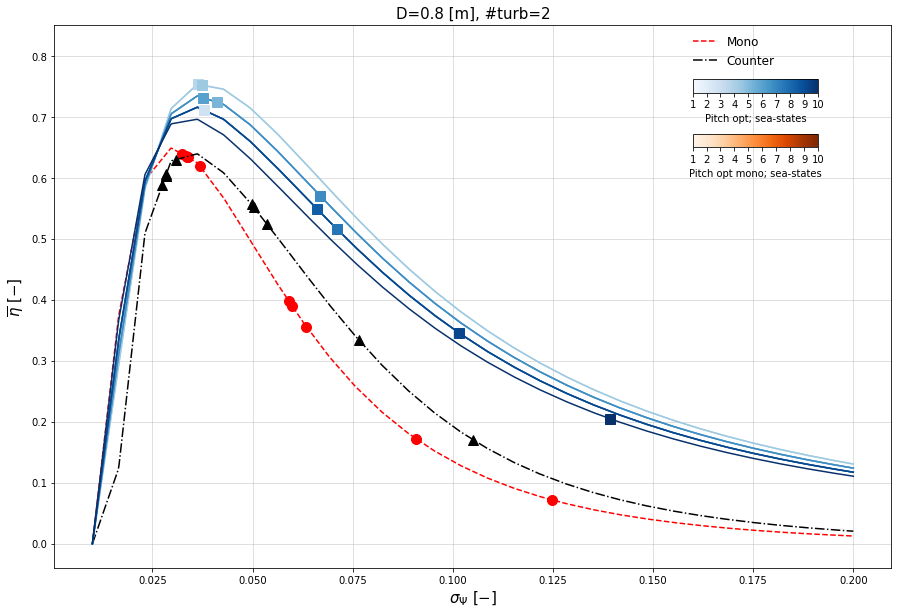

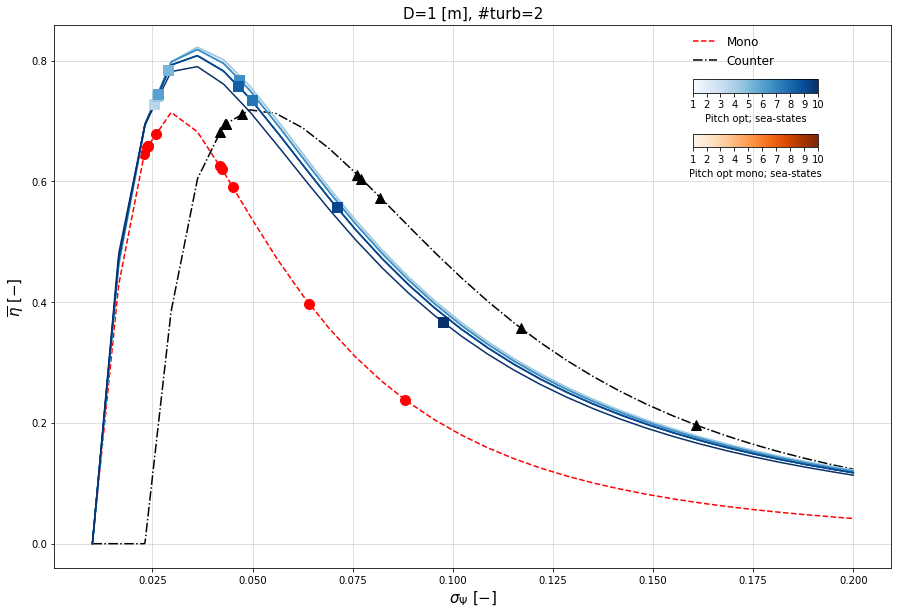

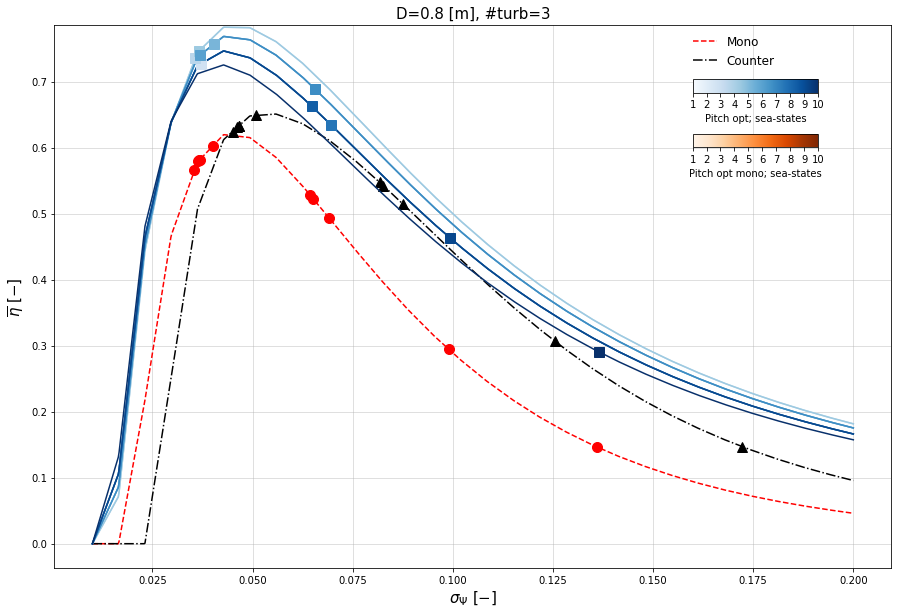

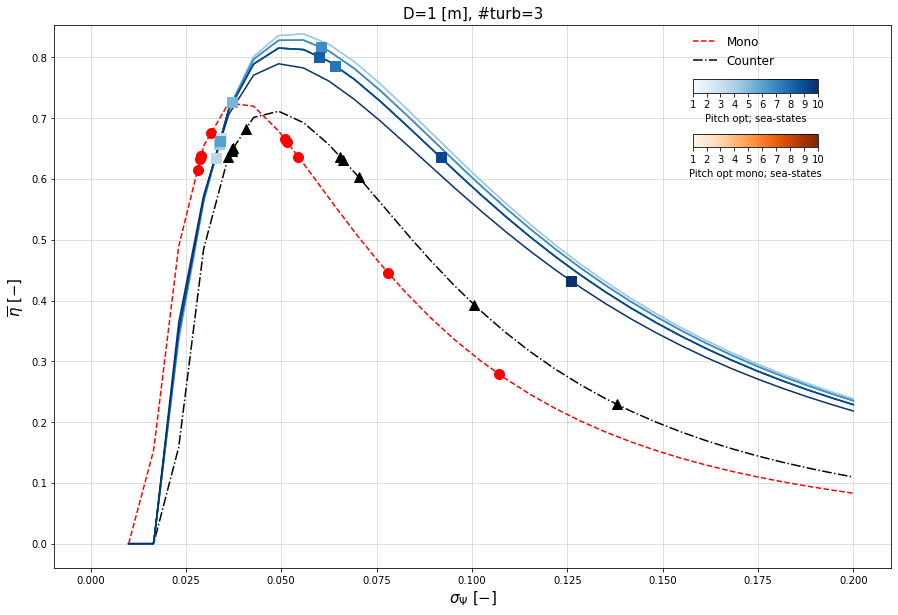

In [11]:
colors = mpl.cm.Blues(np.linspace(0.2, 1, 10))
colors_mono = mpl.cm.Oranges(np.linspace(0.2, 1, 10))

for f in range(0, 4):
    if f == 0:
        xlims = (0.0004999999999999987, 0.20950000000000002)
        ylims = (-0.04055668072480406, 0.8516902952208854)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r04_2T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r04_2T_proc_genes")
        indpitchopt = proc_genes_dataname.index("Pitchopt_fit_IDOM_r04_opts_2T_proc_genes")
        indpitchoptmono = proc_genes_dataname.index("Pitchopt_for_mono_fit_IDOM_r04_2T_proc_genes")
        title = "D=0.8 [m], #turb=2"
        savename = "r04_2T"
    elif f == 1:
        xlims = (0.0004999999999999987, 0.20950000000000002)
        ylims = (-0.04091386276588643, 0.8591911180836151)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r05_2T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r05_2T_proc_genes")
        indpitchopt = proc_genes_dataname.index("Pitchopt_fit_IDOM_r05_opts_2T_proc_genes")
        indpitchoptmono = proc_genes_dataname.index("Pitchopt_for_mono_fit_IDOM_r05_2T_proc_genes")
        title = "D=1 [m], #turb=2"
        savename = "r05_2T"
    elif f == 2:
        xlims = (0.0004999999999999987, 0.20950000000000002)
        ylims = (-0.03745088075261679, 0.7864684958049526)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r04_3T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r04_3T_proc_genes")  
        indpitchopt = proc_genes_dataname.index("Pitchopt_fit_IDOM_r04_opts_3T_proc_genes")
        indpitchoptmono = proc_genes_dataname.index("Pitchopt_for_mono_fit_IDOM_r04_3T_proc_genes")
        title = "D=0.8 [m], #turb=3"
        savename = "r04_3T"
    elif f == 3:
        xlims = (-0.009475000000000003, 0.20997500000000002)
        ylims = (-0.04064643839099119, 0.8535752062108148)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r05_3T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r05_3T_proc_genes")  
        indpitchopt = proc_genes_dataname.index("Pitchopt_fit_IDOM_r05_opts_3T_proc_genes")
        indpitchoptmono = proc_genes_dataname.index("Pitchopt_for_mono_fit_IDOM_r05_3T_proc_genes")
        title = "D=1 [m], #turb=3"
        savename = "r05_3T"
    plt.figure(figsize=(15, 10))
    plt.plot(fitnesses[indmono][0], fitnesses[indmono][1], linestyle='--', color='r', label='Mono')
    for dev, eff in zip(fitnesses[indmono][2], fitnesses[indmono][3]):
        plt.plot(dev, eff, marker='o', markersize=10, color='r')
    plt.plot(fitnesses[indcounter][0], fitnesses[indcounter][1], linestyle='-.', color='k', label='Counter')
    for dev, eff in zip(fitnesses[indcounter][2], fitnesses[indcounter][3]):
        plt.plot(dev, eff, marker='^', markersize=10, color='k')    
    if not indpitchopt is None:
        e = 0
        ticks = list()
        for dev, eff in zip(fitnesses[indpitchopt][0], fitnesses[indpitchopt][1]):
            if len(dev) == 1:
                continue
            plt.plot(dev, eff, color=colors[e])#, label="Pitch opt; sea-state=" + str(e + 1))
            ticks.append(e + 1)
            e += 1            
        for dev, eff in zip(fitnesses[indpitchopt][2], fitnesses[indpitchopt][3]):
            e = 0
            for g, d in enumerate(dev):
                if type(dev[g]) == np.ndarray:
                    continue
                plt.plot(dev[g], eff[g], marker='s', markersize=10, color=colors[e])
                e += 1
#     e = 0
#     ticksmono = list()
#     for dev, eff in zip(fitnesses[indpitchoptmono][0], fitnesses[indpitchoptmono][1]):        
#         if len(dev) == 1 or all([_ == 0 for _ in eff]):
#             continue
#         plt.plot(dev, eff, color=colors_mono[e])#, label="Pitch opt mono; sea-state=" + str(e + 1))
#         ticksmono.append(e + 1)
#         e += 1    
#     for dev, eff in zip(fitnesses[indpitchoptmono][2], fitnesses[indpitchoptmono][3]):
#         e = 0
#         for g, d in enumerate(dev):
#             if eff[g] == 0:
#                 continue
#             plt.plot(dev[g], eff[g], marker='s', markersize=10, color=colors_mono[e])
#             e += 1
            
    plt.gca().set_xlim(xlims)
    plt.gca().set_ylim(ylims)
    plt.legend(frameon=False, fontsize=12, loc=2, bbox_to_anchor=[0.75, 1, 0, 0])
    
    axin1 = plt.gca().inset_axes([0.7625, 0.875, 0.15, 0.025])
    cmap = mpl.cm.Blues
    norm = mpl.colors.Normalize(vmin=1, vmax=10)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=axin1, orientation='horizontal', label='Pitch opt; sea-states', ticks=ticks)
    
    axin2 = plt.gca().inset_axes([0.7625, 0.775, 0.15, 0.025])
    cmap = mpl.cm.Oranges
    norm = mpl.colors.Normalize(vmin=1, vmax=10)
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=axin2, orientation='horizontal', label='Pitch opt mono; sea-states', ticks=ticksmono)
    
    plt.grid(alpha=0.5)
    plt.xlabel("$\\sigma_{\\Psi} \\ [-]$", fontsize=15)
    plt.ylabel("$\\overline{\\eta} \\ [-]$", fontsize=15)
    plt.title(title, fontsize=15)
            
    plt.savefig(".".join([savename, "pdf"]))
    
#     print(sum(fitnesses[indmono][4]))
#     print('----')
#     for _ in fitnesses[indmono][4]:
#         print(_)
#     print("\n")
#     print("\n")
#     print(sum(fitnesses[indcounter][4]))
#     print('----')
#     for _ in fitnesses[indcounter][4]:
#         print(_)
#     print("\n")
#     print("\n")
#     if not indpitchopt is None:
#         print(sum(fitnesses[indpitchopt][4][0]))
#         print('----')
#         for _ in fitnesses[indpitchopt][4][0]:
#             print(_)
#         print("\n")
#         print("\n")
#     print(sum(fitnesses[indpitchoptmono][4][0]))
#     print('----')
#     for _ in fitnesses[indpitchoptmono][4][0]:
#         print(_)
#     print("----------------------------------------")

### Best configuration plottings

Counter_fit_IDOM_r04_2T_proc_genes
Counter_fit_IDOM_r05_2T_proc_genes
Mono_fit_IDOM_r04_2T_proc_genes
Mono_fit_IDOM_r05_2T_proc_genes
Pitchopt_fit_IDOM_r04_opts_2T_proc_genes
Pitchopt_fit_IDOM_r05_opts_2T_proc_genes
Counter_fit_IDOM_r04_3T_proc_genes
Counter_fit_IDOM_r05_3T_proc_genes
Mono_fit_IDOM_r04_3T_proc_genes
Mono_fit_IDOM_r05_3T_proc_genes
Pitchopt_fit_IDOM_r04_opts_3T_proc_genes
Pitchopt_fit_IDOM_r05_opts_3T_proc_genes


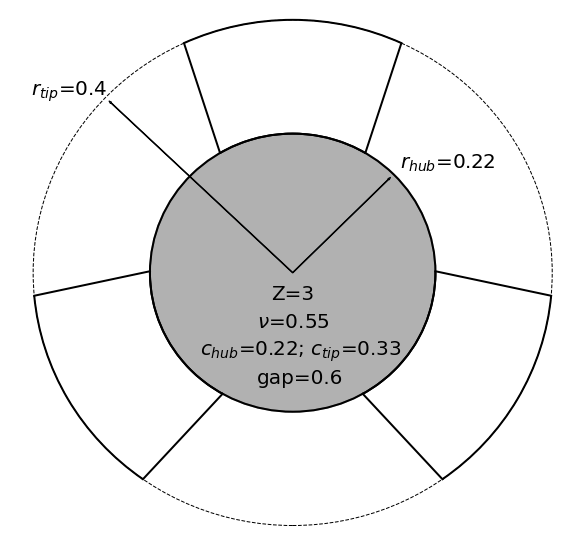

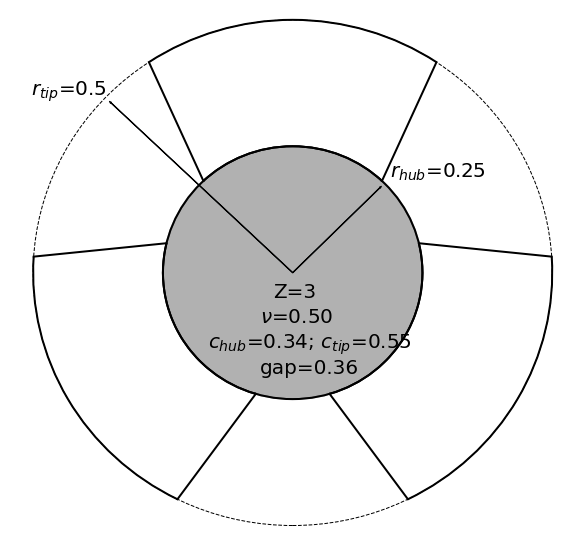

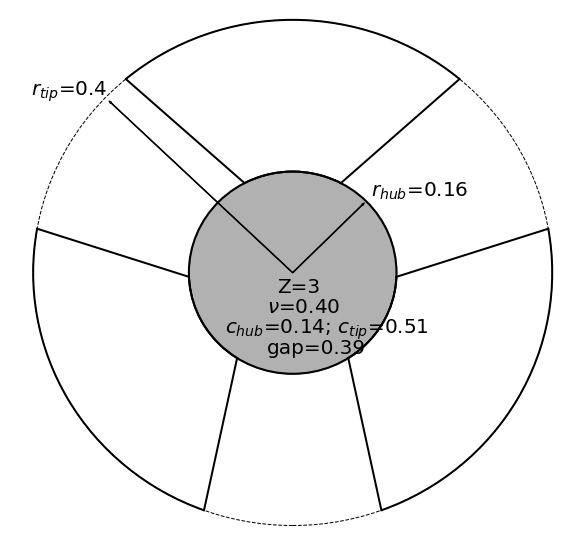

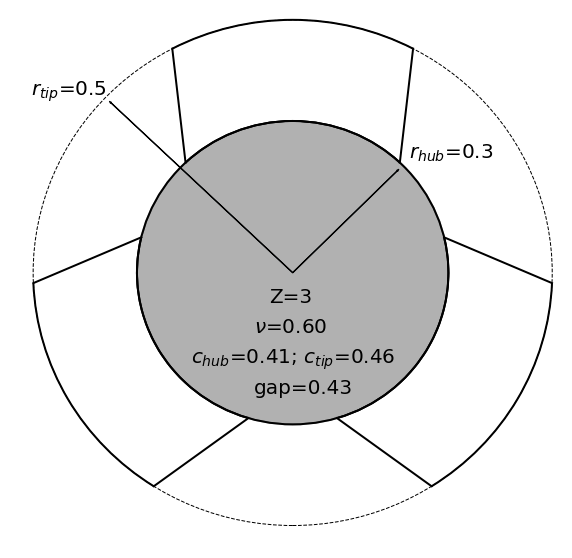

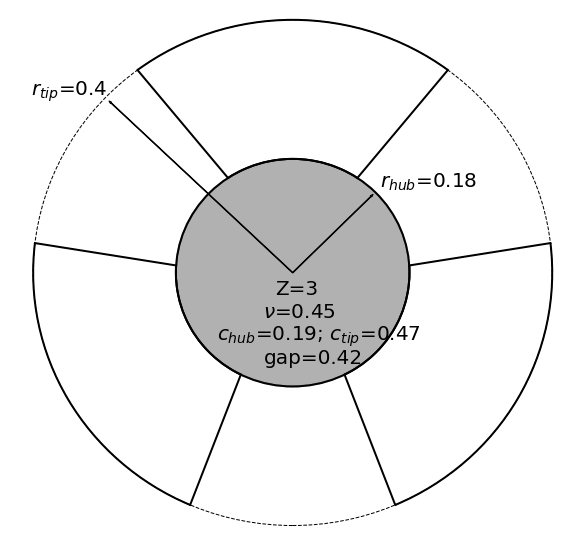

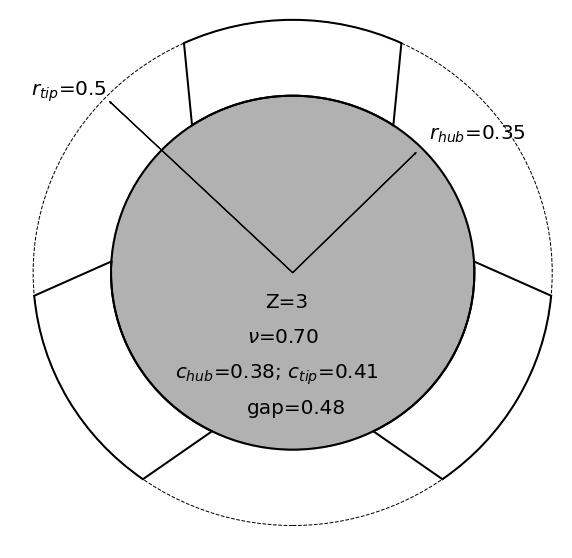

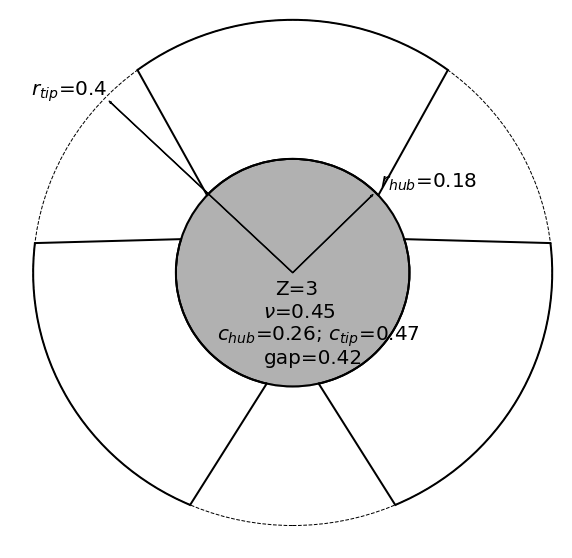

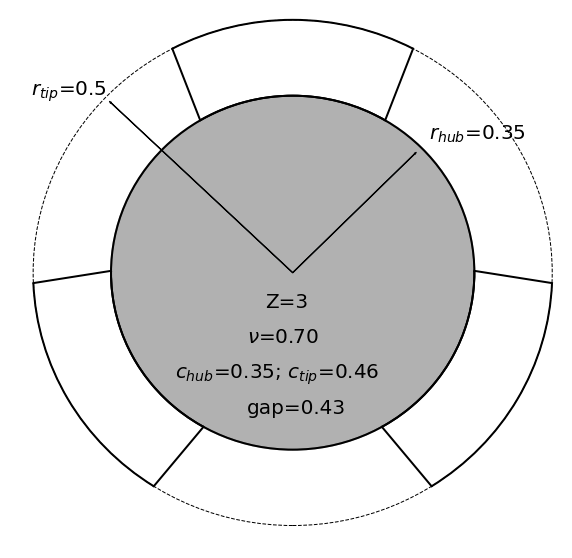

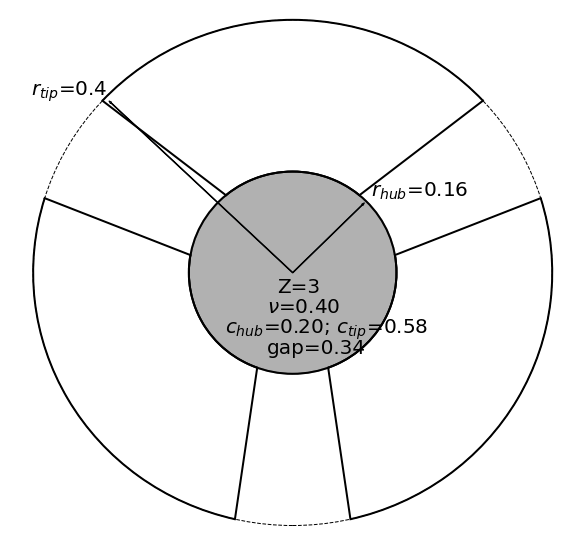

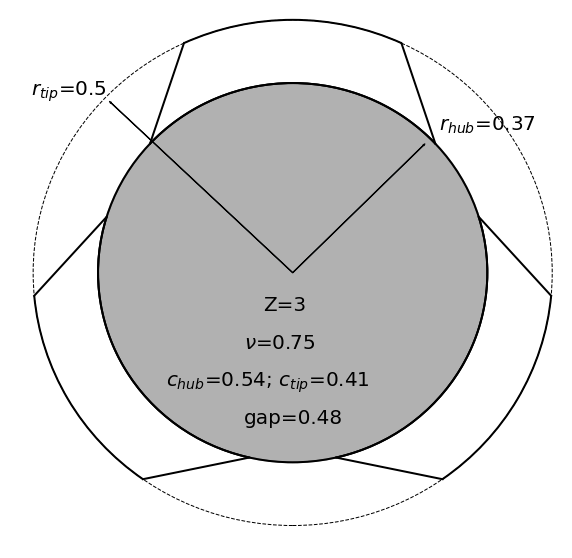

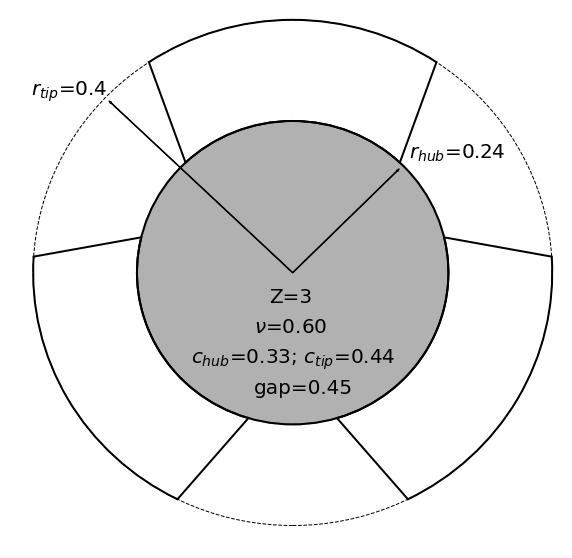

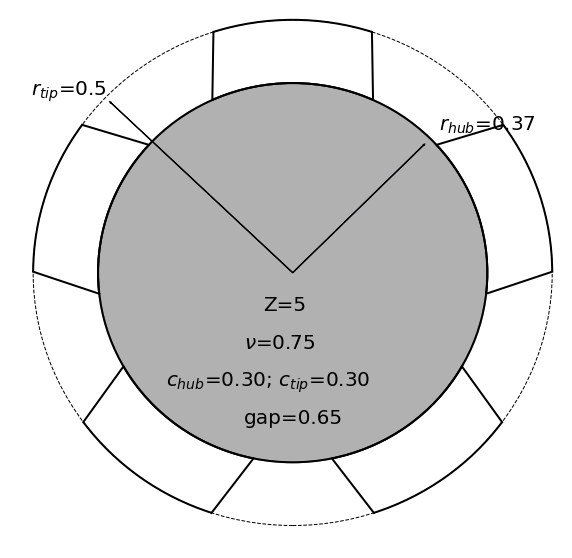

In [7]:
for name in [_ for _ in proc_genes_dataname if "Mono" in _ or "Counter" in _ or ("Pitchopt" in _ and "for_mono" not in _)]:
    ind = proc_genes_dataname.index(name)
    turb = turbs[ind]
    print(name)
    turbine_classes.plot_turbine(turb)

# Calculations for best turbine configurations with $Z$=5

## Mono and counter calculations

In [18]:
proc_genes_dataname = [_ for _ in globals() if "proc_genes" in _ and "IDOM" in _]
proc_genes_data = [globals()[_] for _ in proc_genes_dataname]
turbs = list()
mono_sols = list()
fitnesses = list()
for e, proc_genes in enumerate(proc_genes_data):
    N = 50
    omega = 2100
    Nmin = 1000
    Nmax = 3200
    rcas = 0.5 if "r05" in proc_genes_dataname[e] else 0.4
    airfoils = ["NACA0015", "NACA0018", "NACA0021"]
    polars = polars
    cpobjs = [933.78, 1089.41, 1089.41, 1011.59, 1011.59, 1011.59, 933.78, 933.78, 933.78, 855.96] if "3T" in proc_genes_dataname[e] else [622.52, 726.2733333333334, 726.2733333333334, 674.3933333333333, 674.3933333333333, 674.3933333333333, 622.52, 622.52, 622.52, 570.64]
    devobjs = [2170.82, 2851.59, 2931.97, 2781.80, 2542.296783, 4518.520988, 4087.436172, 3806.379812, 5845.986619, 6745.134759]
    weights = [0.1085, 0.1160, 0.1188, 0.0910, 0.0824, 0.1486, 0.0882, 0.0867, 0.0945, 0.0652]
    mode = "mono" if "Mono" in proc_genes_dataname[e] else "counter"
    constargs = {"N": N,
                 "omega": omega,
                 "rcas": rcas,
                 "airfoils": airfoils,
                 "polars": polars,
                 "cpobjs": cpobjs,
                 "devobjs": devobjs,
                 "weights": weights,
                 "Nmin": Nmin,
                 "Nmax": Nmax,
                 "Mode": mode}    
    solution = list()
    ind5 = proc_genes["Z"].index(5)
    for key in ["Z", "sigma_hub", "sigma_tip", "hub_to_tip_ratio"]:
        solution.append(proc_genes[key][ind5])
    if mode == "mono":
        mono_sols.append([proc_genes_dataname[e]] + solution)
    turbs.append(turbine_classes.instantiate_turbine(constargs, solution))
    fitnesses.append(turbine_classes.fitness_func_noGA(constargs=constargs, turb=turbs[-1], out='stfitness'))

## Pitchopt turbine calculations

In [19]:
# Keeping awake.
set_keepawake(keep_screen_awake=False)

pitchopt_fitnesses = list()
for mono_sol in mono_sols:
    print(mono_sol)
    proc_genes_dataname.append(mono_sol[0].replace("Mono", "pitchopt"))
    N = 50
    omega = 2100
    Nmin = 1000
    Nmax = 3200
    rcas = 0.5 if "r05" in proc_genes_dataname[e] else 0.4
    airfoils = ["NACA0015", "NACA0018", "NACA0021"]
    polars = polars
    cpobjs = [933.78, 1089.41, 1089.41, 1011.59, 1011.59, 1011.59, 933.78, 933.78, 933.78, 855.96] if "2T" in proc_genes_dataname[e] else [622.52, 726.2733333333334, 726.2733333333334, 674.3933333333333, 674.3933333333333, 674.3933333333333, 622.52, 622.52, 622.52, 570.64]
    devobjs = [2170.82, 2851.59, 2931.97, 2781.80, 2542.296783, 4518.520988, 4087.436172, 3806.379812, 5845.986619, 6745.134759]
    weights = [0.1085, 0.1160, 0.1188, 0.0910, 0.0824, 0.1486, 0.0882, 0.0867, 0.0945, 0.0652]
    constargs = {"N": N,
                 "omega": omega,
                 "rcas": rcas,
                 "airfoils": airfoils,
                 "polars": polars,
                 "cpobjs": cpobjs,
                 "devobjs": devobjs,
                 "weights": weights,
                 "Nmin": Nmin,
                 "Nmax": Nmax,
                 "Mode": "pitchopt"}
    turbs.append(turbine_classes.instantiate_turbine(constargs, solution=mono_sol[1:]))
    pitchopt_fitnesses.append(turbine_classes.fitness_func_noGA(constargs=constargs, turb=turbs[-1], out='stfitness'))
    
# Unkeeping awake.
unset_keepawake()

['Mono_fit_IDOM_r04_2T_proc_genes', 5.0, 0.657, 0.571, 0.45]
['Mono_fit_IDOM_r05_2T_proc_genes', 5.0, 0.657, 0.443, 0.6]
['Mono_fit_IDOM_r04_3T_proc_genes', 5.0, 0.657, 0.7, 0.4]
['Mono_fit_IDOM_r05_3T_proc_genes', 5.0, 0.7, 0.4, 0.75]


## Plottings

### Stochastic charts

0.4199205868260772
----
0.0628715474727781
0.06788750384386373
0.06895436005761608
0.05067148153798172
0.04774760840328954
0.049622673795204124
0.02664508680748006
0.029556321813611758
0.01272311732380935
0.0032408857704427398




0.46936788525889844
----
0.06036620855924837
0.0638832556078962
0.06601319688816164
0.05159060867881554
0.04584493626988079
0.06937309202788075
0.03883187607623041
0.040854445028144074
0.02467846386750532
0.007931802255135352




0.5873393740448306
----
0.048730849798704456
0.046171312164702265
0.05093364588987722
0.049059301265280346
0.03645956858722073
0.1172075698122711
0.06869054527351451
0.06706769490644447
0.06758242599552895
0.0354364603512864
----------------------------------------
0.562670830400809
----
0.07013091429579527
0.0738220436545501
0.07663543578726491
0.06022646158591014
0.05326071279238276
0.08523709131040988
0.04788621207299006
0.05010084893042486
0.032649743952798585
0.012721366018282486




0.5565850750490312
----
0.0717724848916603
0.

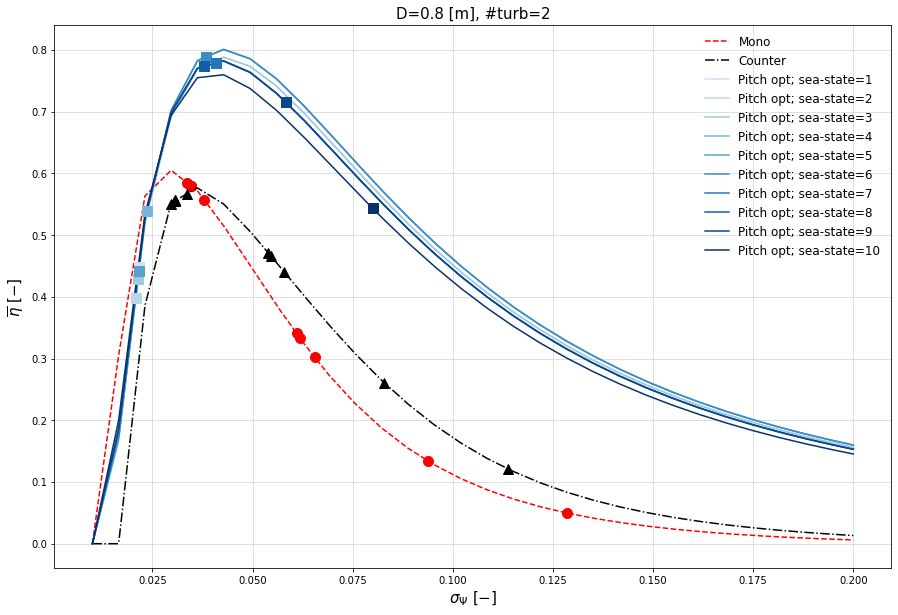

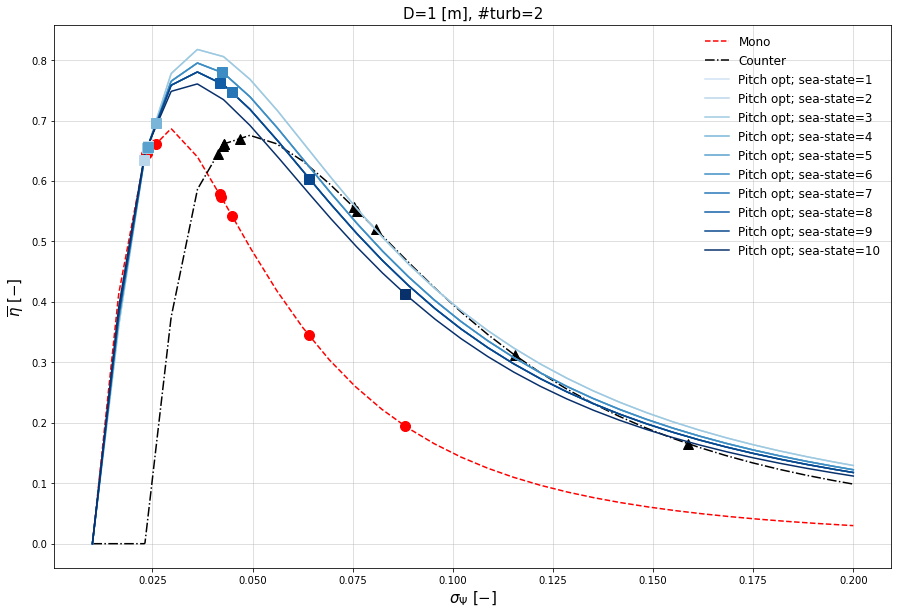

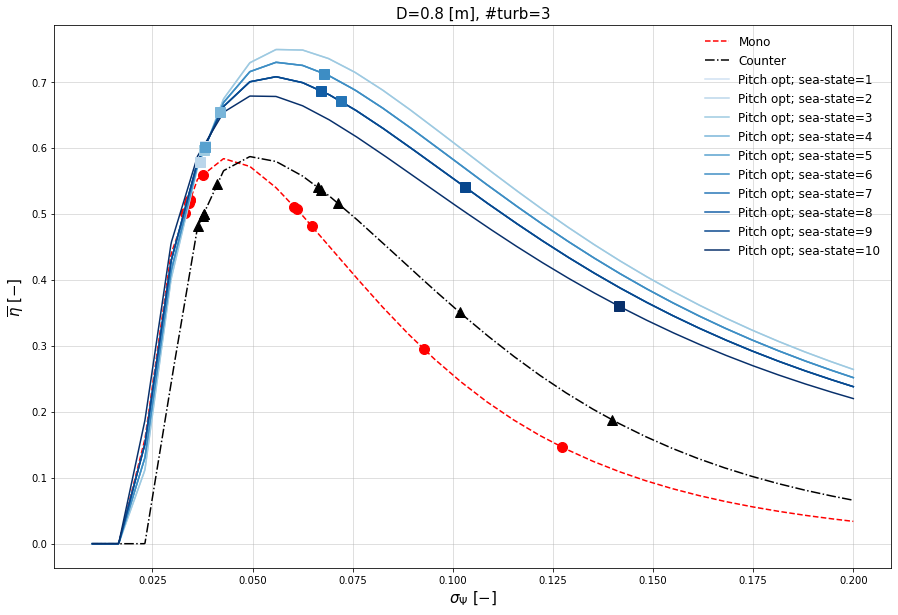

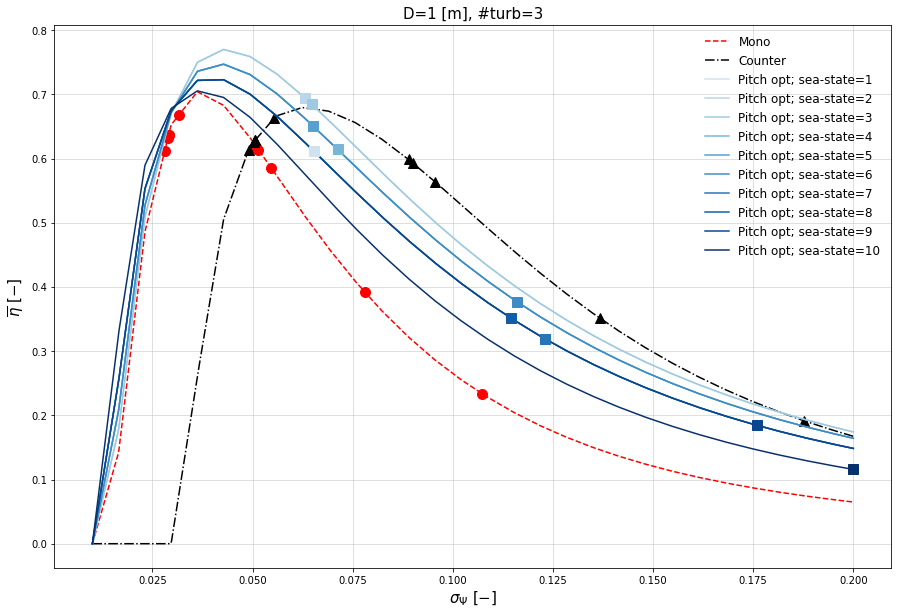

In [29]:
colors = mpl.cm.Blues(np.linspace(0.2, 1, 10))

for f in range(0, 4):
    if f == 0:
        xlims = (0.0004999999999999987, 0.20950000000000002)
        ylims = (-0.04055668072480406, 0.8516902952208854)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r04_2T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r04_2T_proc_genes")
        indpitchopt = proc_genes_dataname.index("pitchopt_fit_IDOM_r04_2T_proc_genes")
        title = "D=0.8 [m], #turb=2"
        savename = "r04_2T"
    elif f == 1:
        xlims = (0.0004999999999999987, 0.20950000000000002)
        ylims = (-0.04091386276588643, 0.8591911180836151)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r05_2T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r05_2T_proc_genes")
        indpitchopt = proc_genes_dataname.index("pitchopt_fit_IDOM_r05_2T_proc_genes")
        title = "D=1 [m], #turb=2"
        savename = "r05_2T"
    elif f == 2:
        xlims = (0.0004999999999999987, 0.20950000000000002)
        ylims = (-0.03745088075261679, 0.7864684958049526)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r04_3T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r04_3T_proc_genes")  
        indpitchopt = proc_genes_dataname.index("pitchopt_fit_IDOM_r04_3T_proc_genes")
        title = "D=0.8 [m], #turb=3"
        savename = "r04_3T"
    elif f == 3:
        xlims = (-0.009475000000000003, 0.20997500000000002)
        ylims = (-0.04064643839099119, 0.8535752062108148)
        indmono = proc_genes_dataname.index("Mono_fit_IDOM_r05_3T_proc_genes")
        indcounter = proc_genes_dataname.index("Counter_fit_IDOM_r05_3T_proc_genes")  
        indpitchopt = proc_genes_dataname.index("pitchopt_fit_IDOM_r05_3T_proc_genes")
        title = "D=1 [m], #turb=3"
        savename = "r05_3T"
    plt.figure(figsize=(15, 10))
    plt.plot(fitnesses[indmono][0], fitnesses[indmono][1], linestyle='--', color='r', label='Mono')
    for dev, eff in zip(fitnesses[indmono][2], fitnesses[indmono][3]):
        plt.plot(dev, eff, marker='o', markersize=10, color='r')
    plt.plot(fitnesses[indcounter][0], fitnesses[indcounter][1], linestyle='-.', color='k', label='Counter')
    for dev, eff in zip(fitnesses[indcounter][2], fitnesses[indcounter][3]):
        plt.plot(dev, eff, marker='^', markersize=10, color='k')
    e = 0
    for dev, eff in zip(pitchopt_fitnesses[indpitchopt%4][0], pitchopt_fitnesses[indpitchopt%4][1]):
        if len(dev) == 1:
            continue
        plt.plot(dev, eff, color=colors[e], label="Pitch opt; sea-state=" + str(e + 1))
        e += 1    
    for dev, eff in zip(pitchopt_fitnesses[indpitchopt%4][2], pitchopt_fitnesses[indpitchopt%4][3]):
        e = 0
        for g, d in enumerate(dev):
            if type(dev[g]) == np.ndarray:
                continue
            plt.plot(dev[g], eff[g], marker='s', markersize=10, color=colors[e])
            e += 1
            
#     plt.gca().set_xlim(xlims)
#     plt.gca().set_ylim(ylims)
    plt.legend(frameon=False, fontsize=12)
    plt.grid(alpha=0.5)
    plt.xlabel("$\\sigma_{\\Psi} \\ [-]$", fontsize=15)
    plt.ylabel("$\\overline{\\eta} \\ [-]$", fontsize=15)
    plt.title(title, fontsize=15)
            
    plt.savefig(".".join([savename, "pdf"]))
    
    print(sum(fitnesses[indmono][4]))
    print('----')
    for _ in fitnesses[indmono][4]:
        print(_)
    print("\n")
    print("\n")
    print(sum(fitnesses[indcounter][4]))
    print('----')
    for _ in fitnesses[indcounter][4]:
        print(_)
    print("\n")
    print("\n")
    print(sum(pitchopt_fitnesses[indpitchopt%4][4][0]))
    print('----')
    for _ in pitchopt_fitnesses[indpitchopt%4][4][0]:
        print(_)        
    print("----------------------------------------")            

### Best configuration plottings

Counter_fit_IDOM_r04_2T_proc_genes
Counter_fit_IDOM_r05_2T_proc_genes
Mono_fit_IDOM_r04_2T_proc_genes
Mono_fit_IDOM_r05_2T_proc_genes
Counter_fit_IDOM_r04_3T_proc_genes
Counter_fit_IDOM_r05_3T_proc_genes
Mono_fit_IDOM_r04_3T_proc_genes
Mono_fit_IDOM_r05_3T_proc_genes


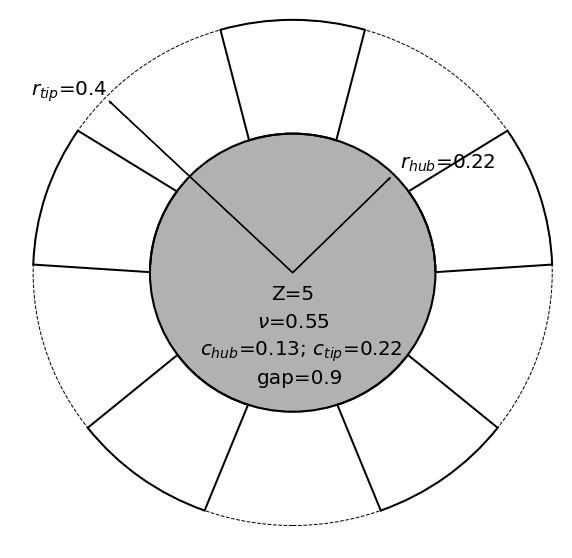

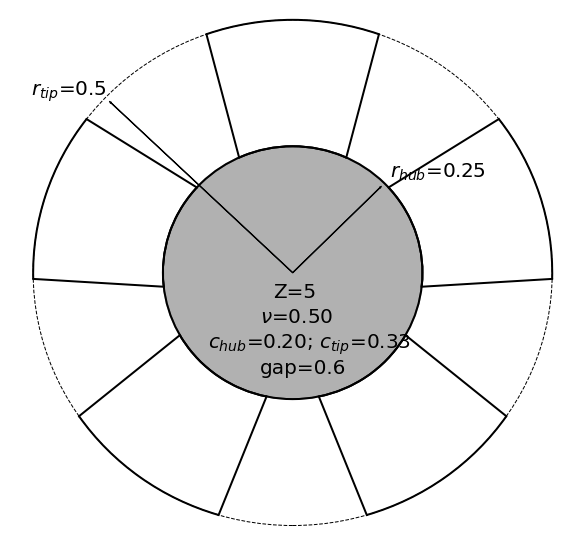

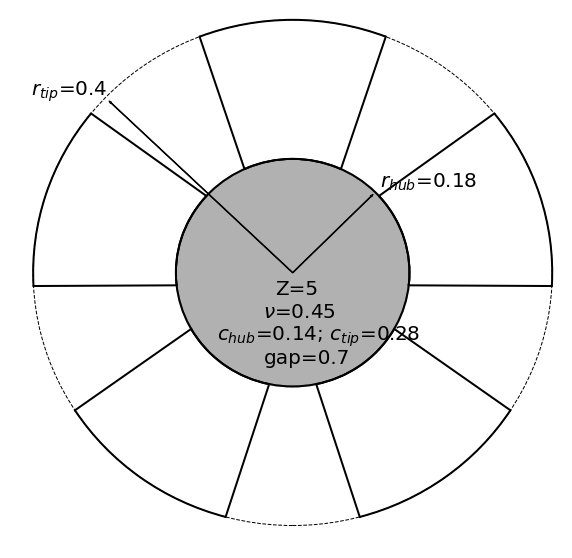

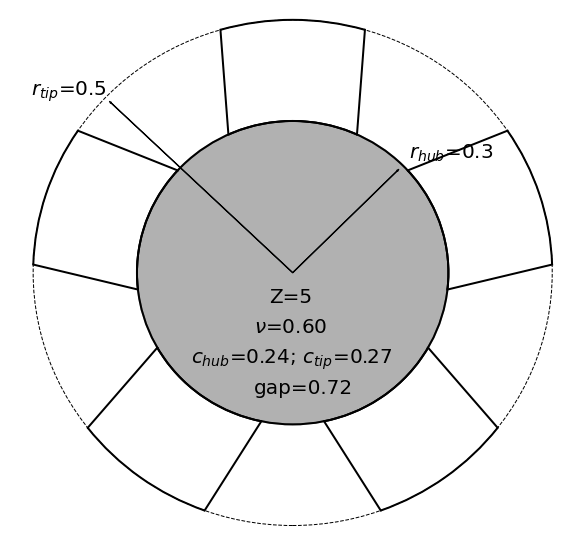

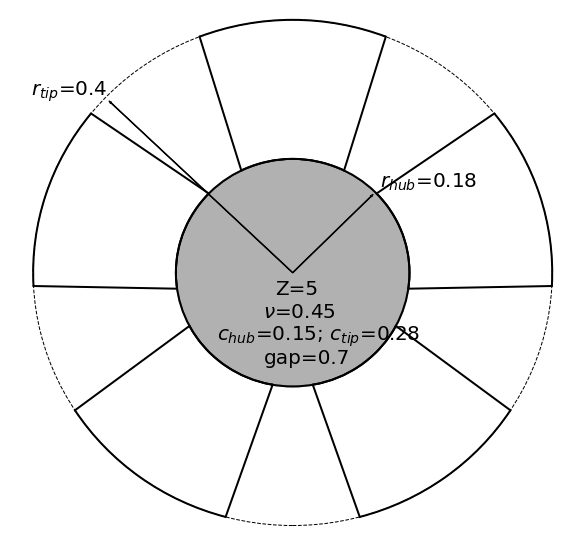

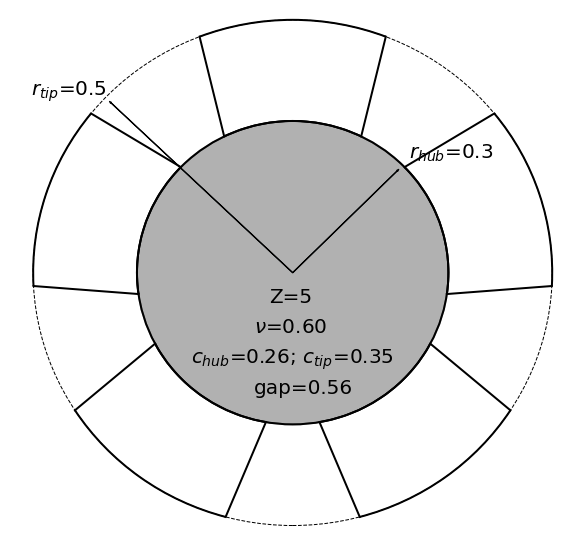

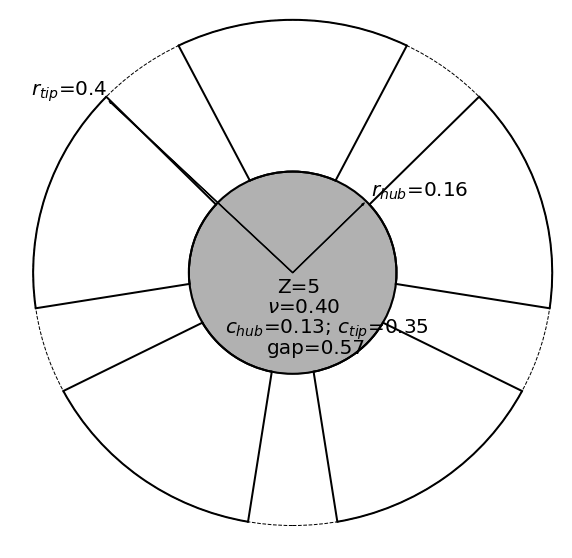

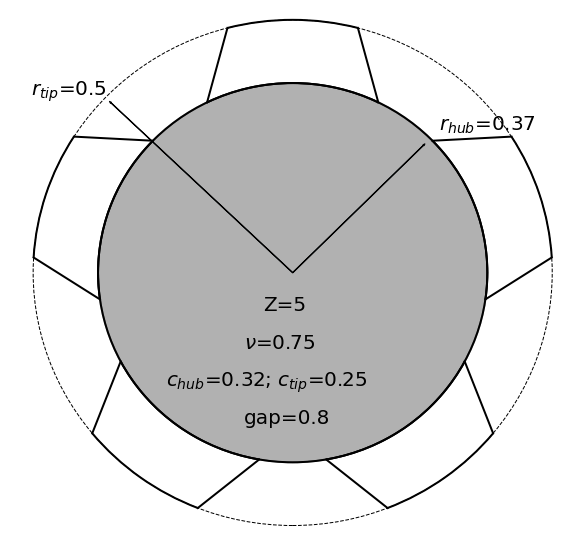

In [32]:
for name in [_ for _ in proc_genes_dataname if "Mono" in _ or "Counter" in _]:
    ind = proc_genes_dataname.index(name)
    turb = turbs[ind]
    print(name)
    turbine_classes.plot_turbine(turb)